[View in Colaboratory](https://colab.research.google.com/github/taowen/understand-neural-network/blob/master/2_first_neural_network.ipynb)

In [1]:
!pip install torch torchvision

neural network 和上一节里说的 y = x * x 本质上一样，都是对 tensor 进行的数学运算。

但是neural network能够做到三点之前的手写规则无法实现的效果：

1. 对任务相关的特征敏感（比如目标是识别狗，可以对狗的图像很敏感）
2. 对任务无关的特征不敏感 （今天拍一张狗，明天再拍一张，都可以识别为狗）
3. 多任务（可以用一个网络实现多种任务）

更简单的说是对真实世界的一些表面上有差异，本质上很类似的物体可以进行识别。这些物体包括我们常见的手写数字，语音，以及人类自然语言等。

我们先来熟悉一下 pytorch 的 api。利用 pytorch 如何写一个最简单的识别数字的例子

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class DigitClassifier(nn.Module):
    def __init__(self):
        super(DigitClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

这个 DigitClassifier 类有什么用？其实它就是一个函数，输入是一个 matrix （2d的tensor）输出是 0 到 9 到数字

given this random image
output:  tensor([[-2.2696, -2.3770, -2.3003, -2.4872, -2.4108, -2.3509, -2.0893,
         -2.2598, -2.1801, -2.3619]])
the classified digit:  tensor([[ 6]])


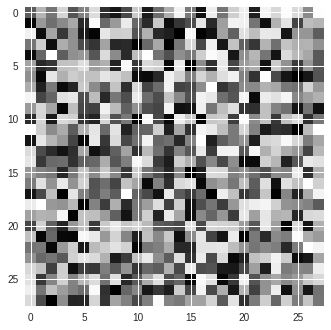

In [3]:
import matplotlib.pyplot as plt

x = torch.rand(
    1, # index in batch
    1, # channel
    28, # height
    28, # width
)
print('given this random image')
plt.imshow(x[0][0], 'gray')
classifier = DigitClassifier()
output = classifier(x)
print('output: ', output)
print('the classified digit: ', output.max(1, keepdim=True)[1])

可以看到 classifier 这个神经网络的实例就是一个函数。它的做用就是把 28 * 28 的灰度图像映射为 0 到 9 的数字

本质上就是一个函数，一个复杂一些的函数

利用第一节里的讲过的梯度下降算法。对于 y = f(x) 我们在给定 x 和 y 的情况下，求解出 f 来。

所以我们先要搞一些数据来

actual:  tensor(5)
classified as:  tensor([ 7])


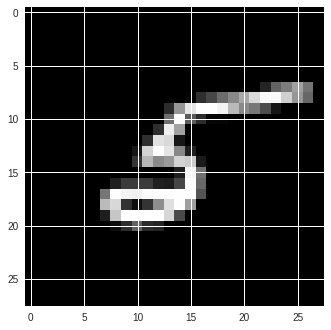

In [4]:
from torchvision import datasets, transforms

transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=True, download=True, transform=transform),
  batch_size=64, shuffle=True, num_workers=1, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=False, transform=transform),
  batch_size=1000, shuffle=True, num_workers=1, pin_memory=True)

# 从训练集里读取一个随机的图片
dataiter = iter(train_loader)
images, labels = dataiter.next()

n = 3 # the 3rd image in the batch
plt.imshow(images[n][0], 'gray')
print('actual: ', labels[n])
classifier.eval() # 设置为 eval 模式
classified = classifier(images).max(1, keepdim=True)[1]
print('classified as: ', classified[n])

我们可以看到，没有经过训练的神经网络还无法对数字进行分类。分类的结果和实际的数字相差很大。

接下来就是要进行训练。首先要定义loss，loss定义对了才能往目标前进

In [5]:
classifier.train() # 设置为训练模式
output = classifier(images)
loss = F.nll_loss(output, labels)
print(loss)

classifier.zero_grad()
loss.backward()

learning_rate = 1e-4
with torch.no_grad():
  for param in classifier.parameters():
    param -= learning_rate * param.grad

tensor(2.3178)


这个更新的过程可以使用现成的optimizer达成同样的目的

多种多样的 optimizer 可以提供比 param -= learning_rate * param.grad 更丰富的选择（不同的更新步长）

In [6]:
import torch.optim as optim

classifier.train() # 设置为训练模式
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.5) 
# 这个optimizer和classifier.parameters()形成了绑定关系，调用optimizer就会更新对应的param

output = classifier(images)
loss = F.nll_loss(output, labels)
print(loss)

optimizer.zero_grad() # was classifier.zero_grad()
loss.backward()

learning_rate = 1e-4
optimizer.step() # was with torch.no_grad() ...

tensor(2.3316)


重复这个过程就是训练了

In [7]:
import torch.optim as optim
import time

learning_rate = 1e-4
classifier.train()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.5) 

def train_classifier():
  for batch_idx, (images, labels) in enumerate(train_loader):
    output = classifier(images)
    loss = F.nll_loss(output, labels)
    if batch_idx % 100 == 0:
      print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
%time train_classifier()

tensor(2.3095)
tensor(2.1289)
tensor(1.1037)
tensor(0.8660)
tensor(1.0582)
tensor(0.8804)
tensor(0.5795)
tensor(0.5391)
tensor(0.3257)
tensor(0.3921)
CPU times: user 20.3 s, sys: 4.56 s, total: 24.9 s
Wall time: 24.5 s


把执行移动到 GPU 上进行，加快速度

In [8]:
import torch.optim as optim
import time

gpu = torch.device("cuda")
learning_rate = 1e-4
classifier = classifier.to(gpu)
classifier.train()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum=0.5) 

def train_classifier():
  for batch_idx, (images, labels) in enumerate(train_loader):
    images, labels = images.to(gpu), labels.to(gpu)
    output = classifier(images)
    loss = F.nll_loss(output, labels)
    if batch_idx % 100 == 0:
      print(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
%time train_classifier()

tensor(0.5357, device='cuda:0')
tensor(0.4337, device='cuda:0')
tensor(0.6912, device='cuda:0')
tensor(0.4114, device='cuda:0')
tensor(0.3777, device='cuda:0')
tensor(0.2065, device='cuda:0')
tensor(0.4662, device='cuda:0')
tensor(0.5486, device='cuda:0')
tensor(0.2636, device='cuda:0')
tensor(0.4928, device='cuda:0')
CPU times: user 6.2 s, sys: 2.14 s, total: 8.34 s
Wall time: 13.9 s


In [9]:
def test_classifier():
    classifier.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(gpu), labels.to(gpu)
            output = classifier(images)
            test_loss += F.nll_loss(output, labels, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
test_classifier()


Test set: Average loss: 0.1213, Accuracy: 9602/10000 (96%)



看到经过训练之后准确率已经不错了，再反复来几遍

In [10]:
for epoch in range(1, 5):
    print('=== epoch', epoch)
    train_classifier()
    test_classifier()

=== epoch 1
tensor(0.1411, device='cuda:0')
tensor(0.1694, device='cuda:0')
tensor(0.3070, device='cuda:0')
tensor(0.1785, device='cuda:0')
tensor(1.00000e-02 *
       6.1945, device='cuda:0')
tensor(1.00000e-02 *
       3.2520, device='cuda:0')
tensor(0.1575, device='cuda:0')
tensor(1.00000e-02 *
       3.7431, device='cuda:0')
tensor(1.00000e-02 *
       5.7541, device='cuda:0')
tensor(1.00000e-02 *
       5.1727, device='cuda:0')

Test set: Average loss: 0.0680, Accuracy: 9781/10000 (98%)

=== epoch 2
tensor(1.00000e-02 *
       5.4730, device='cuda:0')
tensor(1.00000e-02 *
       3.6258, device='cuda:0')
tensor(1.00000e-02 *
       1.0177, device='cuda:0')
tensor(1.00000e-02 *
       8.9760, device='cuda:0')
tensor(1.00000e-02 *
       6.4827, device='cuda:0')
tensor(0.1367, device='cuda:0')
tensor(0.1059, device='cuda:0')
tensor(0.1169, device='cuda:0')
tensor(0.1280, device='cuda:0')
tensor(1.00000e-02 *
       7.4424, device='cuda:0')

Test set: Average loss: 0.0568, Accuracy: 9

最后我们来检验一下成果，随机从测试集里找一个图片，看看是不是能识别对

actual:  tensor(2, device='cuda:0')
classified as:  tensor([ 2], device='cuda:0')


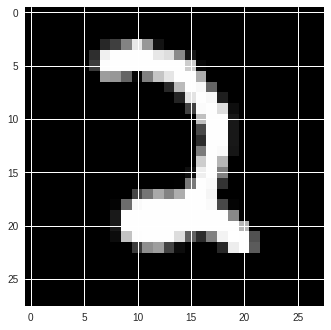

In [12]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images, labels = images.to(gpu), labels.to(gpu)

n = 3 # the 3rd image in the batch
plt.imshow(images[n][0], 'gray')
print('actual: ', labels[n])
classifier.eval() # 设置为 eval 模式
classified = classifier(images).max(1, keepdim=True)[1]
print('classified as: ', classified[n])

我们可以看到识别正确了

但是为什么神经网络可以做到识别不同形状地数字呢？它是如何从输入中发现特征，找到内在规律的呢？

下一节我们来仔细看看内在的工作原理。
